In [2]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 469 (delta 60), reused 97 (delta 45), pack-reused 351
Receiving objects: 100% (469/469), 204.06 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (227/227), done.
Updating files: 100% (94/94), done.


In [3]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [4]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [5]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [6]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [7]:
species_vocal

array(['[UNK]', 'Bacillus_subtilis', 'Staphylococcus_aureus',
       'Escherichia_coli', 'Pseudomonas_aeruginosa', 'Candida_albicans',
       'Pectobacterium_carotovorum', 'Clavibacter_michiganensis',
       'Pseudomonas_corrugata', 'Pseudomonas_syringae',
       'Xanthomonas_vesicatoria', 'Klebsiella_pneumoniae',
       'Staphylococcus_epidermidis', 'Candida_parapsilosis',
       'Micrococcus_luteus', 'Enterococcus_faecium',
       'Enterobacter_cloacae', 'Acinetobacter_baumannii',
       'Bacillus_anthracis', 'Staphylococcus_saprophyticus',
       'Proteus_mirabilis', 'Proteus_vulgaris', 'Salmonella_typhimurium',
       'Saccharomyces_cerevisiae', 'Listonella_anguillarum',
       'Enterobacter_aerogenes', 'Providencia_stuartii',
       'Candida_tropicalis', 'Candida_krusei', 'Salmonella_enterica',
       'Streptococcus_pneumoniae', 'Shigella_sonnei',
       'Enterococcus_faecalis', 'Neisseria_gonorrhoeae',
       'Streptococcus_agalactiae', 'Malassezia_furfur',
       'Trichophyton_m

In [8]:
def onehot2seq(onehot):
    demo_seq = tf.math.argmax(onehot, axis=2)
    demo_seq = pep_decoder(demo_seq).numpy().astype('str')
    demo_seq = ["".join(chars) for chars in demo_seq]
    return demo_seq

In [31]:
# Grid search coordinates
num_bins = 101
labels = np.round(np.linspace(-1, 1, num_bins), 2)
noise = []
for x in labels:
    for y in labels:
        noise.append([x, y])
noise = np.array(noise)
num_sequences = len(noise)

# Look up the index of the target bacteria
target = 'Bacillus_subtilis'
bacteria = np.zeros(shape=(num_sequences, 326))
index = np.where(species_vocal==target)[0][0]
bacteria[:, index] = 1

# Generate sequences and predict MIC
generated_onehot = generator.predict(noise, verbose=0)
MIC = oracle.predict([generated_onehot, bacteria], verbose=0)
generated_sequences = onehot2seq(generated_onehot)
vis_data = np.concatenate([noise, np.array(generated_sequences).reshape(num_sequences, 1), MIC], axis=1)
vis_data = pd.DataFrame(vis_data, columns=["Noise_1", "Noise_2", "Peptide", "MIC"])
vis_data['MIC'] = vis_data['MIC'].astype('float64')
vis_data['Noise_1'] = vis_data['Noise_1'].astype('float64')
vis_data['Noise_2'] = vis_data['Noise_2'].astype('float64')

In [10]:
vis_data.nsmallest(10,'MIC')

,Noise_1,Noise_2,Peptide,MIC
4817,-0.06,0.40,DLLLIFILR,1.822782
4818,-0.06,0.42,DLLLLFILR,1.830127
4716,-0.08,0.40,DLLLLFILR,1.842935
4816,-0.06,0.38,DLLLIFILR,1.851768
4172,-0.18,-0.38,RPIRRR,1.856913
4717,-0.08,0.42,DLLLLFILR,1.863595
4171,-0.18,-0.40,RPIRRR,1.867044
4173,-0.18,-0.36,RPIRRR,1.881519
4271,-0.16,-0.42,RPIRRR,1.886985
4500,-0.12,0.12,RRLRFIR,1.892532


In [13]:
pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.6 MB/s eta 0:00:00


In [14]:
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices

def calculate_blosum62_score(seq1, seq2):
    aligner = PairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    score = aligner.score(seq1, seq2)  # Get the best score
    return score



In [16]:
vis_data

,Noise_1,Noise_2,Peptide,MIC
0,-1.0,-1.00,RPFVPDPPEGT,3.907735
1,-1.0,-0.98,RPFVPDPPEGT,3.849990
2,-1.0,-0.96,RPFVPDPPEGT,3.817035
3,-1.0,-0.94,RPFVPDPPEGT,3.805527
4,-1.0,-0.92,RPFVPDPPEGT,3.805423
...,...,...,...,...
10196,1.0,0.92,KLCWVVPTLYVWIMFRLW,4.001687
10197,1.0,0.94,KLCWVVPTLYVWIMFRLW,3.986347
10198,1.0,0.96,KLCWVVPTLYVWIMFRLW,3.940821
10199,1.0,0.98,KLCWVVPTLYVWIMFRLW,3.883304


In [18]:
vis_data_sorted = vis_data.sort_values(by='MIC')

# Select the top 1,000 rows with the smallest MIC scores
top_1000 = vis_data_sorted.head(1000)
vis_data=top_1000

In [20]:
vis_data

,Noise_1,Noise_2,Peptide,MIC
4817,-0.06,0.40,DLLLIFILR,1.822782
4818,-0.06,0.42,DLLLLFILR,1.830127
4716,-0.08,0.40,DLLLLFILR,1.842935
4816,-0.06,0.38,DLLLIFILR,1.851768
4172,-0.18,-0.38,RPIRRR,1.856913
...,...,...,...,...
4090,-0.20,0.00,RPYMFFR,2.656685
9089,0.78,1.00,KLCGAAPTLYKWIMFRLW,2.656716
3191,-0.38,0.20,VPYVFDR,2.656785
5663,0.12,-0.86,MLPLIIL,2.657029


In [23]:
results = []

# Calculate BLOSUM62 scores for each pair of sequences
for i in range(len(vis_data)):
    for j in range(i+1, len(vis_data)):  # Ensure j > i to avoid redundant comparisons
        peptide1 = vis_data['Peptide'].iloc[i]
        peptide2 = vis_data['Peptide'].iloc[j]
        score = calculate_blosum62_score(peptide1, peptide2)
        results.append({
            "Sequence_1": peptide1,
            "Sequence_2": peptide2,
            "BLOSUM62_Score": score
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                Sequence_1 Sequence_2  BLOSUM62_Score
0                DLLLIFILR  DLLLLFILR            39.0
1                DLLLIFILR  DLLLLFILR            39.0
2                DLLLIFILR  DLLLIFILR            41.0
3                DLLLIFILR     RPIRRR           -13.0
4                DLLLIFILR  DLLLLFILR            39.0
...                    ...        ...             ...
499495  KLCGAAPTLYKWIMFRLW    MLPLIIL           -13.5
499496  KLCGAAPTLYKWIMFRLW    VPYVFLR           -14.5
499497             VPYVFDR    MLPLIIL            -9.0
499498             VPYVFDR    VPYVFLR            29.0
499499             MLPLIIL    VPYVFLR            -4.0

[499500 rows x 3 columns]


In [27]:
# from scipy.cluster.hierarchy import dendrogram, linkage


# unique_sequences = sorted(set(results_df['Sequence_1']).union(set(results_df['Sequence_2'])))
# index_dict = {seq: index for index, seq in enumerate(unique_sequences)}
# distance_matrix = np.full((len(unique_sequences), len(unique_sequences)), np.inf)

# # Fill the distance matrix
# for _, row in results_df.iterrows():
#     i, j = index_dict[row['Sequence_1']], index_dict[row['Sequence_2']]
#     # Convert score to distance (you might need to adjust this based on your scoring)
#     distance = max(results_df['BLOSUM62_Score']) - row['BLOSUM62_Score']
#     distance_matrix[i, j] = distance
#     distance_matrix[j, i] = distance

# # Fill diagonal with zeros
# np.fill_diagonal(distance_matrix, 0)

# # Perform hierarchical clustering
# Z = linkage(distance_matrix, 'ward')

# # Plot dendrogram
# plt.figure(figsize=(10, 7))
# dendrogram(Z, labels=unique_sequences)
# plt.title("Hierarchical Clustering of Peptide Sequences")
# plt.xlabel("Sequence")
# plt.ylabel("Distance")
# plt.show()

In [25]:
from sklearn.cluster import KMeans
# Initialize a dictionary to store total scores and counts for each sequence
score_totals = {seq: 0 for seq in set(results_df['Sequence_1']).union(set(results_df['Sequence_2']))}
score_counts = {seq: 0 for seq in set(results_df['Sequence_1']).union(set(results_df['Sequence_2']))}

# Sum up all scores and count them for each sequence
for _, row in results_df.iterrows():
    score_totals[row['Sequence_1']] += row['BLOSUM62_Score']
    score_counts[row['Sequence_1']] += 1
    score_totals[row['Sequence_2']] += row['BLOSUM62_Score']
    score_counts[row['Sequence_2']] += 1


average_scores = {seq: total / score_counts[seq] for seq, total in score_totals.items()}
data_for_clustering = np.array(list(average_scores.values())).reshape(-1, 1)

#  K-means clustering
num_clusters = 5  # Adjust this as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(data_for_clustering)

# Assign clusters
sequence_clusters = {seq: kmeans.labels_[i] for i, seq in enumerate(average_scores.keys())}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


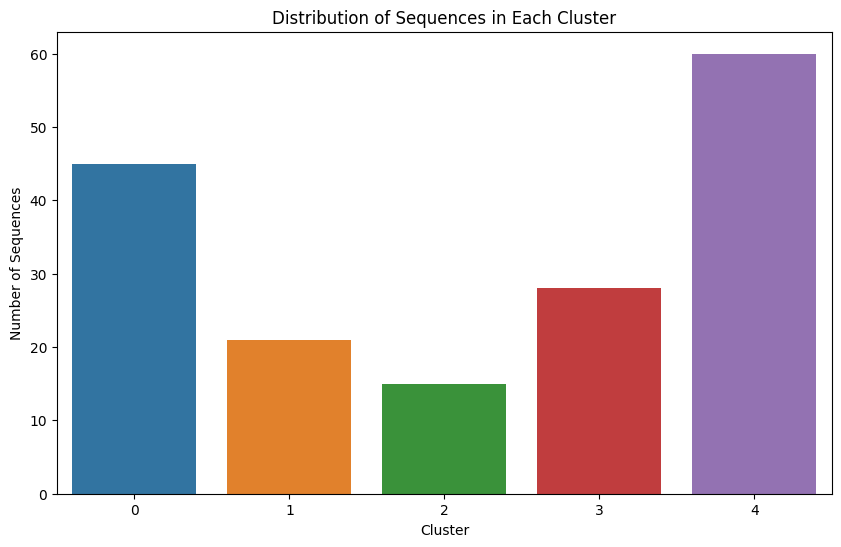

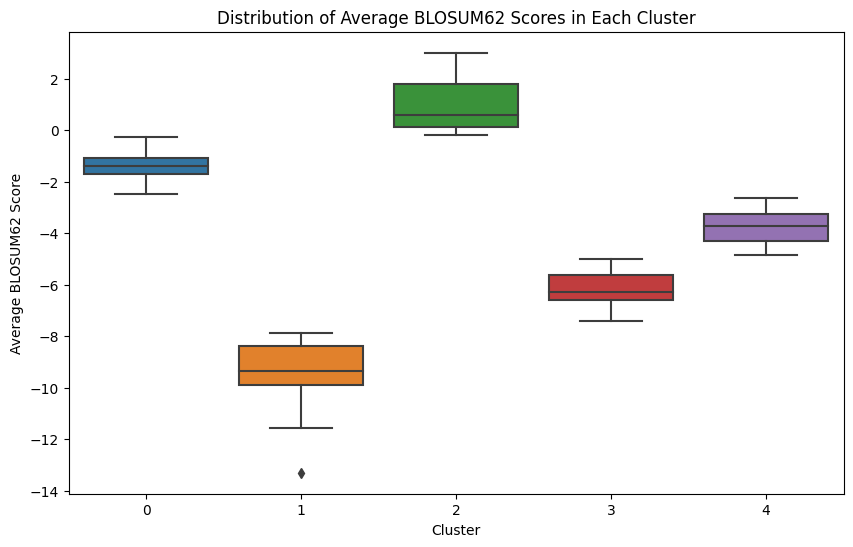

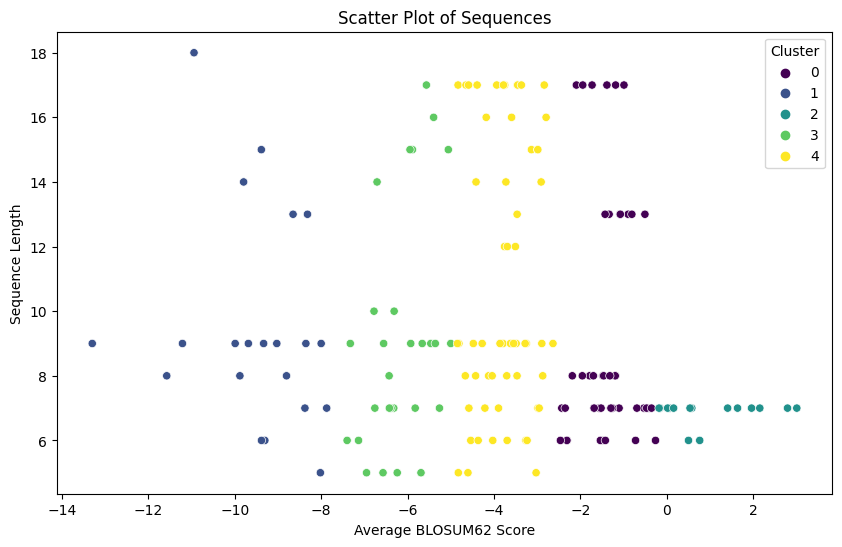

In [28]:
# Convert the sequence_clusters to a DataFrame for easier plotting
cluster_df = pd.DataFrame(list(sequence_clusters.items()), columns=['Sequence', 'Cluster'])
cluster_df['Average_BLOSUM62_Score'] = cluster_df['Sequence'].map(average_scores)

# Histogram of Clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=cluster_df)
plt.title('Distribution of Sequences in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Sequences')
plt.show()

# Box Plot of BLOSUM62 Scores by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Average_BLOSUM62_Score', data=cluster_df)
plt.title('Distribution of Average BLOSUM62 Scores in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average BLOSUM62 Score')
plt.show()

# Scatter Plot (assuming you have a second feature; for example, let's use sequence length)
cluster_df['Sequence_Length'] = cluster_df['Sequence'].apply(len)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_BLOSUM62_Score', y='Sequence_Length', hue='Cluster', data=cluster_df, palette='viridis')
plt.title('Scatter Plot of Sequences')
plt.xlabel('Average BLOSUM62 Score')
plt.ylabel('Sequence Length')
plt.show()


In [26]:
sequence_clusters

{'RRLRFIR': 0,
 'RAKKAIKAAVELMFQ': 1,
 'DLLLIFRLR': 4,
 'DLLLLFILR': 4,
 'DMLKLLLKAGKRLIF': 4,
 'RLALIFILR': 4,
 'RPIRFRR': 2,
 'ALLGAAPYALKRLL': 3,
 'RPIRFR': 2,
 'RPIRRR': 0,
 'RPYVFDR': 0,
 'DLLKLLLKAGKRL': 0,
 'VPYMFFR': 4,
 'DLLLAPLAKL': 3,
 'RIQLLFILR': 4,
 'DIQLLFILR': 4,
 'RPLRFRR': 2,
 'RIALIFILR': 4,
 'RRLRFRI': 0,
 'VKQGLFLWR': 1,
 'RRLRFR': 0,
 'ALLKALPYLGKRLL': 4,
 'RLPLPIRL': 0,
 'RPLRFIR': 2,
 'DKQGLFLWR': 1,
 'VPQYVFLR': 4,
 'RRLRFRLR': 0,
 'ALLGALPYLYKEIMFRL': 4,
 'ALLGAAPYLYKRIMFRL': 4,
 'VKQGGFLWR': 1,
 'VPQYVFLFR': 3,
 'ALLGAVPYLYKRIML': 3,
 'DMLKLLLKAGKRI': 0,
 'MLPLIIL': 3,
 'VPYMGF': 1,
 'ALLGAVPYLYKRIMRL': 4,
 'MPIPPI': 3,
 'DLALIFILR': 3,
 'ALLKALPYLGKEILFRL': 0,
 'RRLRFRR': 2,
 'KLLGALPTLYKWIMFRL': 4,
 'ALLGAVPYLYKEIMFRL': 4,
 'RIQLIFILR': 4,
 'DMLKLLAKAGKRL': 0,
 'VPYMGDR': 3,
 'DLLKLLLLAGKRL': 0,
 'RRLRARL': 4,
 'RLPLAIRL': 0,
 'ALLGAAPTLYKEIMFRL': 3,
 'MPIPI': 3,
 'RPYRFIR': 2,
 'MLPLAIL': 3,
 'RLLPIRL': 0,
 'RILRIRL': 0,
 'RPIPP': 3,
 'VRQYMFLFR': 3,
 'DLL

In [32]:
vis_data['Noise_1_bins'] = pd.cut(vis_data['Noise_1'], bins=num_bins, labels=labels)
vis_data['Noise_2_bins'] = pd.cut(vis_data['Noise_2'], bins=num_bins, labels=labels)

# Group the data by the bins and calculate the mean MIC
grouped = vis_data.groupby(['Noise_1_bins', 'Noise_2_bins'])
grid_mic_mean = grouped['MIC'].mean().reset_index()

# Pivot the results to create a grid that `sns.heatmap` can visualize
grid_mic_mean_pivot = grid_mic_mean.pivot('Noise_1_bins', 'Noise_2_bins', 'MIC')

<ipython-input-32-f0fb43b98688>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grid_mic_mean_pivot = grid_mic_mean.pivot('Noise_1_bins', 'Noise_2_bins', 'MIC')


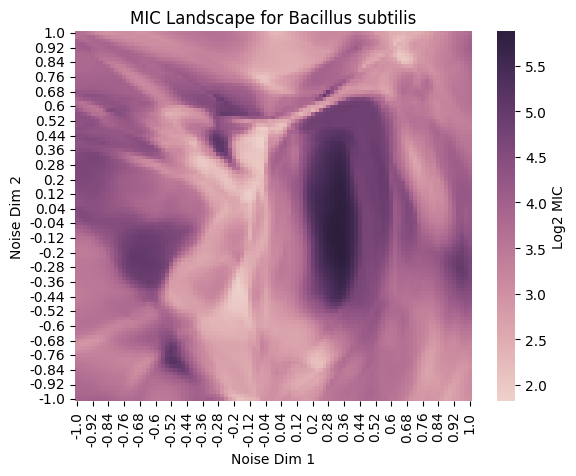

In [33]:
h = sns.heatmap(grid_mic_mean_pivot.transpose().iloc[::-1],
                cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Log2 MIC'})
h.set(xlabel="Noise Dim 1", ylabel="Noise Dim 2", title=f"MIC Landscape for {target.split('_')[0]} {target.split('_')[1]}")
plt.savefig(f"{target}.png", dpi=200, bbox_inches='tight')